<a href="https://colab.research.google.com/github/Crendal/Machine_learning/blob/main/%EA%B1%B0%EC%8B%9C%EC%A7%80%ED%91%9C%ED%81%AC%EB%A1%A4%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 시장국면 파악을 위한 거시지표 크롤링
> 보통 경제 사이클 구분할 때, 경기(경제성장)과 물가라는 2개의 변수를 기준으로 구별한다 - 삼성증권 보고서

> 경제 성장 지표와 경기 후행 지표인 물가를 같이 고려하여, 국면 분류의 유용성이 커짐.

|경기국면|경기|물가|설명|
|:---:|:---:|:---:|:---:|
|Recovery|+|-|경기상승, 물가하락|
|Expansion|+|+|경기상승, 물가상승|
|Slowdown|-|+|경기하락, 물가상승|
|Contraction|-|-|경기하락, 물가하락|

- https://ecos.bok.or.kr/api/#/DevGuide/StatisticalCodeSearch : 한국은행 통계코드 검색하는 곳

- 경기지표:보통 일반적으로, 분기 경제성장률, 경기선행지수 등 사용(분기에 나온 다는 점이 시차가 발생)
 > 월간 수출 증가율 수치의 historical 4년 z-score을 사용
 > 통계코드 : 403Y001
- 물가지표:월간 물가 상승률 수치 기반, 과거 4년 기준 z-score 사용
 > 통계코드 : 901Y009

In [ ]:
# 한국은행 ECOS api를 이용해서 필요한 정보 추출
# *AA
# 2013.01부터 월별 cpi 추출해서 res데이터 프레임에 저장
import pandas as pd
import requests
import json
from pandas.io.json import json_normalize


# 201301과 같은 형태의 '년월'이 포함된 date_list 생성
from datetime import datetime, timedelta
import time
start_date = datetime(2008, 12,1)
end_date = datetime(2023, 9, 30)

current_date = start_date
date_list = []

while current_date <= end_date:
    year = current_date.year
    month = current_date.month
    date_string = f"{year}{month:02d}"  # 월을 두 자리 숫자로 표현
    date_list.append(date_string)
    current_date = current_date.replace(day=1) + timedelta(days=32)  # 다음 달의 1일로 이동

def get_ecos(stat_code, start_date, end_date, name, cycle_type='M'):
    url = f"http://ecos.bok.or.kr/api/StatisticSearch/QQGDEPOH62DTLE5S8O7V/json/kr/1/10/{stat_code}/{cycle_type}/{start_date}/{end_date}/"
    response = requests.get(url)
    data = response.json()

    # ECOS api에서 필요한 년월까지 정보를 추출
    try:
        # 필요한 정보를 추출합니다.
        rows = data['StatisticSearch']['row']
        if isinstance(rows, dict):
            rows = [rows]
        # 데이터프레임에 데이터를 저장합니다.
        df = pd.DataFrame(rows)
        # 필요한 컬럼만 선택합니다.
        df = df[['TIME', 'DATA_VALUE', 'ITEM_NAME1']]
        # 컬럼 이름을 변경합니다.
        df.columns = ['date', name, '품목']
        # 'date' 컬럼을 datetime 형식으로 변환합니다.
        df['date'] = pd.to_datetime(df['date'], format='%Y%m')
        # '품목' 컬럼을 총지수로 필터링합니다.
        df = df[df['품목'] == '총지수']
        # 필요한 컬럼만 선택합니다.
        df = df[['date', name]]
        return df



    except KeyError:
        print("key error")
        return None  # 데이터가 없는 경우 None을 반환합니다.


In [ ]:
# 소비자 물가지수 데이터 수집
res = pd.DataFrame()
for i in date_list:
  df_1 =get_ecos("901Y009",i,'202309',name='소비자물가지수')
  res = pd.concat([df_1, res],axis=0)
  time.sleep(0.5)
res.sort_values('date', ascending=True,inplace=True)
res.set_index('date',inplace=True)
res['소비자물가지수'] = res['소비자물가지수'].astype(float)
res['증감률'] = res['소비자물가지수'].pct_change()
res.dropna(inplace=True)
print(f"소비자물가지수 데이터를 {start_date}~{end_date}까지 수집해, res 데이터 프레임에 저장하였습니다")

key error
소비자물가지수 데이터를 2008-12-01 00:00:00~2023-09-30 00:00:00까지 수집해, res 데이터 프레임에 저장하였습니다


In [ ]:
res

,소비자물가지수,증감률
date,,
2009-01-01,82.450,0.000910
2009-02-01,83.045,0.007216
2009-03-01,83.640,0.007165
2009-04-01,83.862,0.002654
2009-05-01,83.862,0.000000
...,...,...
2023-04-01,110.800,0.002171
2023-05-01,111.130,0.002978
2023-06-01,111.120,-0.000090


In [ ]:
# 수출금액지수 데이터 수집
res_1 = pd.DataFrame()
for i in date_list:
  df_2 =get_ecos("403Y001",i,'202309', name='수출금액지수')
  res_1 = pd.concat([df_2, res_1],axis=0)
  time.sleep(0.5)
res_1.sort_values('date', ascending=True,inplace=True)
res_1.set_index('date',inplace=True)
res_1['수출금액지수'] = res_1['수출금액지수'].astype(float)
res_1['증감률'] = res_1['수출금액지수'].pct_change()
res_1.dropna(inplace=True)
print(f"{'수출금액지수'} 데이터를 {start_date}~{end_date}까지 수집해, res_1 데이터 프레임에 저장하였습니다")

key error
수출금액지수 데이터를 2008-12-01 00:00:00~2023-09-30 00:00:00까지 수집해, res_1 데이터 프레임에 저장하였습니다


In [ ]:
res_1

,수출금액지수,증감률
date,,
2009-01-01,46.33,-0.156256
2009-02-01,52.53,0.133823
2009-03-01,59.26,0.128117
2009-04-01,63.17,0.065980
2009-05-01,60.09,-0.048757
...,...,...
2023-04-01,118.14,-0.111729
2023-05-01,125.47,0.062045
2023-06-01,126.86,0.011078


In [ ]:
# 물가 상승률 4년 기준 z-score 구하는 함수
import numpy as np
import pandas as pd
def fouryear_z_score(df, current_time_index, window_size=48 ):
  df = pd.DataFrame(df['증감률'], index=pd.to_datetime(df.index))
  historical_inflation_rates = df[['증감률']]
  current_time_index = pd.to_datetime(current_time_index)
  row_number = df.index.get_loc(current_time_index)
  historical_inflation_rates.reset_index(inplace=True)


  # 구하고자하는 시간대에 대한 행 넘버를 구해 그 전 48개(4year)에 대한 평균과 표준 편차를 구하기
  selected_data = historical_inflation_rates.iloc[row_number-window_size:row_number]
  mean_rate = selected_data.loc[:,'증감률'].mean()
  std_deviation = selected_data.loc[:,'증감률'].std()
  current_month_rate = df.loc[current_time_index, '증감률']

# 현재 달의 z-score 계산
  z_score = (current_month_rate - mean_rate) / std_deviation

# Interpret the z-score
  if z_score > 0:
      interpretation = "+"
  elif z_score < 0:
      interpretation = "-"

  else:
      interpretation = "0"

  return z_score

In [ ]:
res.loc['2012-12-01']

소비자물가지수    92.175000
증감률         0.001782
Name: 2012-12-01 00:00:00, dtype: float64

In [ ]:
fouryear_z_score(df=res, current_time_index='2013-02-01')


Current Month's Inflation Rate: 0.0033431110344233073
Mean Inflation Rate (Past 4 Years): 0.002456283837116232
Standard Deviation of Inflation Rates: 0.0034527751884338314
Z-Score: 0.25684475498948933, (+)



|경기국면|경기|물가|설명|그래프|
|:---:|:---:|:---:|:---:|:---:|
|Recovery|+|-|경기상승, 물가하락|-0.5|
|Expansion|+|+|경기상승, 물가상승|0.5|
|Slowdown|-|+|경기하락, 물가상승|0.5|
|Contraction|-|-|경기하락, 물가하락|-0.5|

In [ ]:
# 특정 월의 경기국면 상황 판단 함수
# time 형태 '####-##-01' 연-월 데이터
def business_cycle(time):
  a = fouryear_z_score(df=res, current_time_index=time)
  b = fouryear_z_score(df=res_1, current_time_index=time)

  if a > 0 and b < 0:
    print('Recovery')
  elif a > 0 and b > 0:
    print('Expansion')
  elif a < 0 and b > 0:
    print('Slowdown')
  else:
    print('Contraction')


In [154]:
# 2013-01-01 부터 입력가능
business_cycle('2018-05-01')

Slowdown


In [ ]:
# 특정 월의 경기국면 상황 판단 함수
# time 형태 '####-##-01' 연-월 데이터
def business_cycle(time):
  a = fouryear_z_score(df=res, current_time_index=time)
  b = fouryear_z_score(df=res_1, current_time_index=time)

  if a > 0 and b < 0:
    print('Recovery')

  elif a > 0 and b > 0:
    print('Expansion')
  elif a < 0 and b > 0:
    print('Slowdown')
  else:
    print('Contraction')


In [181]:
# 그림그려보기
from datetime import datetime, timedelta
import time
start_date = datetime(2013, 1,1)
end_date = datetime(2023, 9, 1)

current_date = start_date
date_list = []
while current_date <= end_date:
    year = current_date.year
    month = current_date.month
    date_string = f"{year}{month:02d}"  # 월을 두 자리 숫자로 표현
    date_list.append(date_string)
    current_date = current_date.replace(day=1) + timedelta(days=32)  # 다음 달의 1일로 이동
date_list = [f'{date[:4]}-{date[4:6]}-01' for date in date_list]

date_list = pd.to_datetime(date_list)
table = pd.DataFrame()
date_list = pd.to_datetime(date_list)

for i in date_list:
  cycle = business_cycle(i)
  total_cycle = pd.concat([cycle, table])
total_cycle

Recovery
Recovery
Slowdown
Contraction
Slowdown
Contraction
Expansion
Recovery
Contraction
Slowdown
Contraction
Contraction
Recovery
Recovery
Slowdown
Slowdown
Contraction
Contraction
Slowdown
Contraction
Slowdown
Slowdown
Contraction
Slowdown
Recovery
Contraction
Slowdown
Contraction
Recovery
Slowdown
Recovery
Recovery
Slowdown
Slowdown
Contraction
Expansion
Recovery
Recovery
Slowdown
Recovery
Slowdown
Slowdown
Contraction
Recovery
Expansion
Expansion
Slowdown
Expansion
Recovery
Expansion
Slowdown
Contraction
Recovery
Slowdown
Recovery
Expansion
Expansion
Contraction
Slowdown
Recovery
Expansion
Recovery
Slowdown
Recovery
Slowdown
Contraction
Contraction
Expansion
Recovery
Slowdown
Contraction
Contraction
Contraction
Recovery
Slowdown
Expansion
Recovery
Contraction
Slowdown
Recovery
Expansion
Expansion
Contraction
Expansion
Recovery
Contraction
Slowdown
Contraction
Contraction
Expansion
Slowdown
Recovery
Expansion
Contraction
Slowdown
Expansion
Recovery
Recovery
Expansion
Recovery
Cont

""


In [182]:
type(total_cycle)

pandas.core.frame.DataFrame

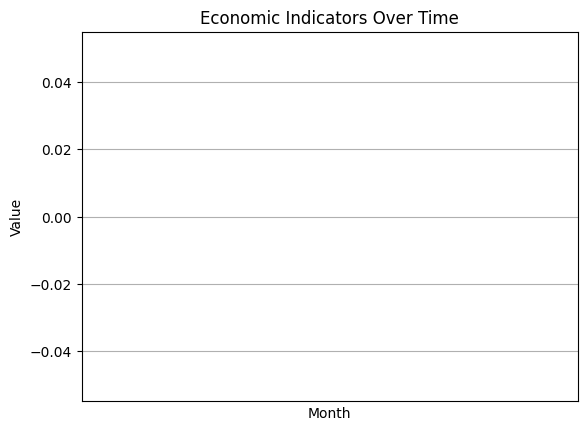

In [173]:
# import matplotlib.pyplot as plt
# data = {
#     'Recovery': -0.5,
#     'Slowdown': 0.5,
#     'Contraction': -0.5,
#     'Expansion': 0.5
# }

# # total_cycle에 해당하는 값을 추출하여 리스트로 저장
# values = [data[word] for word in total_cycle]

# # 월별로 꺾은선 그래프 그리기
# plt.plot(values, marker='o', linestyle='-')
# plt.xticks(range(len(total_cycle)), total_cycle, rotation=90)  # x 축에 월 별 데이터를 나타내기
# plt.xlabel('Month')
# plt.ylabel('Value')
# plt.title('Economic Indicators Over Time')
# plt.grid(True)

# # 그래프 표시
# plt.show()